# Chapter 11: HHL Algorithm

Harrow-Hassidim-Lloyd (HHL) algorithm for linear systems.

---

**Note:** This notebook corresponds to Chapter 11 of the textbook.

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [16]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt

# Add utilities to path
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / 'utilities'))

# Import common utilities
from quantum_utils import simulateCircuit #type: ignore

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate, QFTGate
from qiskit.circuit.library import QFT, phase_estimation, HamiltonianGate
from qiskit.circuit.library.standard_gates.u import UGate
from qiskit_aer import Aer
print('Setup complete!')

Setup complete!


In [17]:
import scipy
import numpy as np

## HHL Algorithm

In [18]:

class myHHL:
	# This is the hybrid version of the HHL algorithm where we explicitly 
	# construct and simulate the QPE circuit. The results are the used in 
	# the  HLL circuit
	def __init__(self, A, b, lambdaUpper,
			  m = 3,P0 = 0.1,nShots = 1000):	
		self.A = A
		self.b = b
		self.lambdaUpper = lambdaUpper # Used in Hamiltonian evolution. 
		self.m = m # Number of bits to estimate the eigenphasess
		self.nHHLShots = nShots # for simulating HHL circuit
		self.nQPEShots = nShots # for simulating QPE circuit
		self.N = self.A.shape[0]
		self.n = int(np.log2(self.N)) # number of qubits to capture b
		self.dataOK = True
		self.probabilityCutoff = P0 # for pruning QPE eigenphases
		if np.abs(2**self.n - self.A.shape[0]) > 1e-10: 
			print("Invalid size of matrix; must be power of 2") 
			self.dataOK = False
		if (self.n > 10):
			print('Matrix size is too large')
			self.dataOK = False
		symErr = np.max(self.A - np.transpose(self.A))
		if (symErr > 0):
			print('A does not appear to be symmetric')
			self.dataOK = False
		if (not np.isclose(np.linalg.norm(b), 1.0)):
			print('b does not appear to be of unit magnitude')
			self.dataOK = False
		if (m < 1):
			print('m has to be at least 1')
			self.dataOK = False
		if not (A.shape[0] == b.shape[0]):
			print('A and b sizes are not compatible')
			self.dataOK = False
			
		self.debug = False
	
	def solveuExact(self):
		# used for verification and not part of HHL
		self.xExact = scipy.linalg.solve(self.A, self.b)
		self.uExact = self.xExact/np.linalg.norm(self.xExact)

	def computeEigen(self):
		# used for verification and not part of HHL
		self.eig_val, self.eig_vec = scipy.linalg.eig(self.A)
		# Since A is assumed to be symmetric, the eigen values are real
		self.eig_val = np.abs(self.eig_val)# get rid of imaginary component

	def estimate_lambda_bounds_gershgorin(self):
		"""Estimate eigenvalue bounds using Gershgorin Circle Theorem"""
		n = self.A.shape[0]
		lambda_upper_bound = -np.inf
		lambda_lower_bound = np.inf
		
		for i in range(n):
			center = self.A[i, i]
			radius = np.sum(np.abs(self.A[i, :])) - np.abs(self.A[i, i])
			lambda_upper_bound = max(lambda_upper_bound, center + radius)
			lambda_lower_bound = min(lambda_lower_bound, center - radius)
		
		# For symmetric positive definite, ensure lower bound > 0
		if lambda_lower_bound <= 0:
			# Try column-wise Gershgorin
			for j in range(n):
				center = self.A[j, j]
				radius = np.sum(np.abs(self.A[:, j])) - np.abs(self.A[j, j])
				lambda_lower_bound = max(lambda_lower_bound, center - radius)
		
		return lambda_lower_bound, lambda_upper_bound

	
		
	def simulateCircuit(self,circuit,nShots=1000):
		backend = Aer.get_backend('qasm_simulator')
		new_circuit = transpile(circuit, backend)
		job = backend.run(new_circuit,shots = nShots)
		counts = job.result().get_counts(circuit)
		return counts

	def constructQPECircuit(self,mode):
		# Constructing QPE circuit for 3 different instances:
		# (1) QPE mode, (2) HHL front end amd (3) HLL rear end
		phase_qubits = QuantumRegister(self.m, '\u03B8')
		b_qubits = QuantumRegister(self.n, 'b')
		if (mode == 'QPE'):
			offset = 0 # since there is no ancillary qubit
			cl = ClassicalRegister(self.m,'cl')
			circuit = QuantumCircuit( phase_qubits, b_qubits,cl)
		elif (mode == 'HHLFront') or (mode == 'HHLRear'):
			ancilla_qubit = QuantumRegister(1,'a')
			offset = 1 # since there is an ancillary qubit
			cl = ClassicalRegister(1+self.n,'cl')
			circuit = QuantumCircuit(ancilla_qubit, phase_qubits, b_qubits,cl)	
		else:
			print('Incorrect mode in constructQPECircuit')
			return
			
		for i in range(self.m):
			circuit.h(offset+i) # Initial set of Hadamards for QPE
		if (mode == 'QPE') or (mode == 'HHLFront'): # 
			circuit.prepare_state(Statevector(self.b),
						 [*range(self.m+offset, self.n+self.m+offset)],'b')
			
		t = -2*np.pi/self.lambdaUpper #Note negative
		U_A = HamiltonianGate(self.A, time=t,label = 'UA')
		U_A._name = 'UA'
		for i in range(self.m): # standard operations for phase kickback
			U_A_pow = U_A.power(2**i) 
			UControl = U_A_pow.control(1) # only 1 control qubit
			circuit.append(UControl,[i+offset,*range(self.m+offset, self.n+self.m+offset)])
		
		qft = QFTGate(num_qubits=self.m).inverse() # standard IQFT
		if (mode == 'QPE') or (mode == 'HHLFront'):
			qft._name = 'IQFT'
		elif (mode == 'HHLRear'):
			qft._name = 'QFT' #we will apply inverse later
		circuit.append(qft, [*range(offset,self.m+offset)])
		return circuit
	
	def processQPECounts(self,counts):
		# process QPE counts dictionary
		# First sort descending using 2nd item in dictionary
		self.QPECountsSorted = {k: v for k, v in sorted(self.QPECounts.items(), 
											 key=lambda item: item[1],
											 reverse=True)}
		self.thetaTilde  = np.array([])	
		for key in self.QPECountsSorted:
			thetaValue = int(key, 2)/(2**self.m) # string to decimal-10
			probability = self.QPECountsSorted[key]/self.nQPEShots
			if ((thetaValue == 0) or  # to avoid division by zer0
				(probability < self.probabilityCutoff)): # phase pruning
				continue
			self.thetaTilde  = np.append(self.thetaTilde,thetaValue)
	
	def constructHHLCircuit(self):
		self.HHLCircuit = self.constructQPECircuit('HHLFront') # QPE circuit
		self.HHLCircuit.barrier()
		for key in self.QPECountsSorted:# Controlled rotation
			thetaValue = int(key, 2)/(2**self.m) 
			probability = self.QPECountsSorted[key]/self.nQPEShots
			if (thetaValue == 0) or (probability < self.probabilityCutoff):
				continue
			lambdaTilde = thetaValue*self.lambdaUpper
			if (self.lambdaLower > lambdaTilde):
				continue # skip since invalid. See text for details
			
			alpha = 2*np.arcsin(self.lambdaLower/lambdaTilde)	
			cu_gate = UGate(alpha, 0, 0).control(self.m, ctrl_state = key) 
			self.HHLCircuit.append(cu_gate,[*range(1,1+self.m),0])
			
		qpeInverse = self.constructQPECircuit('HHLRear').inverse() #IQPE
		self.HHLCircuit.barrier()
		self.HHLCircuit.compose(qpeInverse,
						  [*range(0,1+self.m+self.n)], 
						  [*range(0,1+self.n)],inplace = True)
		
		self.HHLCircuit.barrier()
		self.HHLCircuit.measure(qubit = [0,
								   *range(1+self.m,1+self.m+self.n)], 
							  cbit =  [0,*range(1,self.n+1)]) 
		#self.HHLCircuit.draw('mpl')
		
	def extractHHLSolution(self):
		self.HHLSuccessCounts = {}
		nSuccessCounts = 0
		for key in self.HHLRawCounts: # gather useful simuulations
			if (key[-1] == '1'): # if the ancillary bit is 1
				self.HHLSuccessCounts[key] = self.HHLRawCounts[key]
				nSuccessCounts += self.HHLSuccessCounts[key]
		self.uHHL = 0
		if (nSuccessCounts == 0):
			return False
		for key in self.HHLSuccessCounts:
			subkey = key[0:-1] # remove the ancillary bit
			v = np.real(Statevector.from_label(subkey)) # extract v 
			self.uHHL = self.uHHL + v*(np.sqrt(self.HHLSuccessCounts[key]/nSuccessCounts))
		return True
	
	def executeHHL(self):
		if not self.dataOK:
			print('Check input data')
			return False
		# In executeHHL:
		lambda_lower_gershgorin, lambda_upper_gershgorin = self.estimate_lambda_bounds_gershgorin()

	
		## Step 1: Construct  QPE circuit and estimate theta
		self.QPECircuit = self.constructQPECircuit('QPE')
		self.QPECircuit.measure([*range(0,self.m)], [*range(0,self.m)]) 
		self.QPECounts = self.simulateCircuit(self.QPECircuit,self.nQPEShots)
		self.processQPECounts(self.QPECounts)
		
		# Use QPE-based estimate if tighter, otherwise use Gershgorin
		if len(self.thetaTilde) > 0:
			lambda_lower_qpe = 0.99 * min(self.thetaTilde) * self.lambdaUpper
			self.lambdaLower = max(lambda_lower_gershgorin * 0.99, lambda_lower_qpe)
		else:
			self.lambdaLower = lambda_lower_gershgorin * 0.99
			
		print(f"λ_lower (Gershgorin): {lambda_lower_gershgorin:.6f}")
		print(f"λ_lower (QPE): {lambda_lower_qpe:.6f}" if len(self.thetaTilde) > 0 else "")
		print(f"λ_lower (used): {self.lambdaLower:.6f}")

		self.constructHHLCircuit()
		self.HHLRawCounts = self.simulateCircuit(self.HHLCircuit,self.nHHLShots)
		if not self.extractHHLSolution():
			return False
		return True
	
	def debugHHL(self):
		self.computeEigen()
		print("Exact eigen values of A:\n", self.eig_val)
		print("Exact eigen vectors of A:\n", self.eig_vec)
		eigenPhase = self.b*self.eig_val/self.lambdaUpper
		tMax = 2*np.pi/max(self.eig_val)
		print("Exact eigenphases of A:\n", eigenPhase)
		if (max(eigenPhase) >= 1):
			print('Invalid value for lambdaUpper and/or fs', self.lambdaUpper,self.f)
			print('Here choose t to be <', abs(tMax))
		
		self.solveuExact() # used for verification
		print('xExact:', self.xExact)
		

## HHL Examples

In [24]:
example = 1
debug = False
nShots = 1000
if (example == 1):
	A = np.array([[1,0],[0,0.75]])
	v0 = np.array([0,1])
	v1 = np.array([1,0])
	D = [0.75,1]
	b = np.array([1/np.sqrt(2),1/np.sqrt(2)])
	lambdaUpper = 2
	m = 2
	P0 = 0.1
elif (example == 2):
	A = np.array([[2,-1],[-1,2]])
	v0 = np.array([1/np.sqrt(2),1/np.sqrt(2)])
	v1 = np.array([1/np.sqrt(2),-1/np.sqrt(2)])
	D = [1,3]
	b = np.array([-1/np.sqrt(2),1/np.sqrt(2)])
	lambdaUpper = 6
	m = 5
	P0 = 0.1
elif (example == 3):
	A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
	v0 = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
	v1 = np.array([0,1,0,0])
	v2 = np.array([0,0,1,0])
	v3 = np.array([1/np.sqrt(2),0,0,-1/np.sqrt(2)])
	D = [0.5,1,1,1.5]
	#a = [1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4)]
	a = [0,0,1,0]
	b = a[0]*v0 + a[1]*v1 + a[2]*v2 + a[3]*v3
	lambdaUpper = 3
	m = 2
	P0 = 0.1
	# Example for N-dimensional Poisson matrix
elif example == 4:
	N = 4  # dimension of the Poisson matrix
	A = 2 * np.eye(N) - np.eye(N, k=1) - np.eye(N, k=-1)
	# Dirichlet boundary conditions: b = [1, 0, ..., 0]
	b = np.zeros(N)
	b[0] = 1
	D = np.linalg.eigvalsh(A)
	lambdaUpper = np.max(D)
	m = 3
	P0 = 0.1

print('A:\n', A)
print('b:\n', b)

A:
 [[1.   0.  ]
 [0.   0.75]]
b:
 [0.70710678 0.70710678]


## HHL Execution on a specific QLSP

In [25]:
HHL = myHHL(A,b,lambdaUpper = lambdaUpper,
				 m = m,P0 = P0, nShots = nShots)
	
# Execute main code
if (HHL.executeHHL()):
	print("uHHL: \t\t\t", HHL.uHHL)
	HHL.solveuExact()
	print('uExact: \t\t', HHL.uExact)
	fidelity = np.dot(HHL.uHHL,HHL.uExact)
	print('fidelity:', fidelity)
	HHL.debugHHL()

λ_lower (Gershgorin): 0.750000
λ_lower (QPE): 0.495000
λ_lower (used): 0.742500
uHHL: 			 [0.82031838 0.57190711]
uExact: 		 [0.6 0.8]
fidelity: 0.9497167225839598
Exact eigen values of A:
 [1.   0.75]
Exact eigen vectors of A:
 [[1. 0.]
 [0. 1.]]
Exact eigenphases of A:
 [0.35355339 0.26516504]
xExact: [0.70710678 0.94280904]


## HHL fidelity vs nShots for varying qubits

Text(0, 0.5, 'Average fidelity')

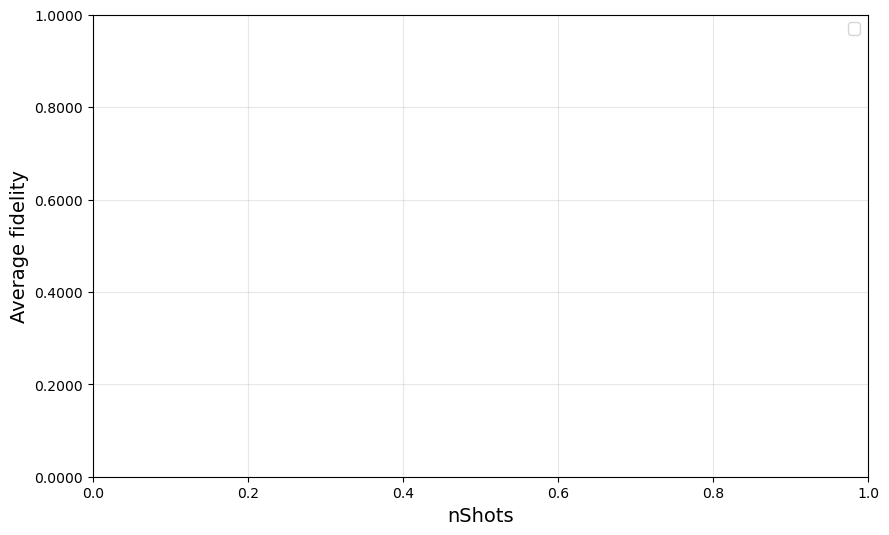

In [26]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
shots = [10,25,50,100,500,1000]
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
mValues = [] #[2,3,5]
lineType = ['-','--',':','-.']
expt = 0
for m in mValues:
	fidelityResult= []
	print("m: ",m)
	for nShots in shots:
		print("nShots: ",nShots)
		fAverage = 0
		HHL = myHHL(A,b,lambdaUpper = lambdaUpper, m = m, P0 = P0, nShots = nShots)
		HHL.solveuExact()
		nSuccessfulTrials = 0
		nTrials = 25
		for t in range(nTrials):
			if (not HHL.executeHHL()):
				continue
			nSuccessfulTrials = nSuccessfulTrials +1
			fidelity = np.dot(HHL.uHHL,HHL.uExact)
			fAverage = fAverage + fidelity
		fAverage = fAverage/nSuccessfulTrials
		print("fAverage:", fAverage)
		fidelityResult.append(fAverage)
	
	plt.semilogx(shots, fidelityResult,lineType[expt])
	expt = expt +1

plt.legend(['m=2','m=3','m=5'])
plt.grid(visible = True)
plt.xlabel("nShots", fontsize = 14)
plt.ylabel("Average fidelity", fontsize = 14)

